# Model proto

This is a rough prototype of our RL solution

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import time
import sys
import os

if '..' not in sys.path: sys.path.append('..')

from src.utils.common import *
from src.utils.plot_utils import *
from src.dnd.actions import *
from src.dnd.units import *
from src.dnd.game_utils import *
from src.agent.agent import DnDAgent
from src.agent.deep_q_network import *
from src.agent.agent_utils import get_legal_action_resolver, get_states, agents_play_loop
from src.agent.training import train_loop_trivial, calculate_reward_classic
from src.dnd.game_configs import *

In [3]:
seed_everything(1234, deterministic_cudnn=True)

## Sample agent game

In [4]:
def custom_reward(game, unit: Unit, player_id: int, move_legal: bool, action_legal: bool, updates: dict):
        units_removed = updates['units_removed']
        reward = -0.05
        game_over = False
        # reward for removing enemy units, 1 for each unit
        reward += len([x for x in units_removed if x[1] != player_id])
        # reward for defeating players
        reward += 5 * len([x for x in units_removed if len(game.players_to_units[x[1]]) == 0 and x[1] != player_id])
        # reward for winning
        if len(game.players_to_units[player_id]) == len(game.units):
            game_over = True
            reward += 10
        # penalty for losing (on your own turn ??)
        if len(game.players_to_units[player_id]) == 0:
            game_over = True
            reward = -10
        
        return reward, game_over

In [5]:
board_size, game_config = get_2v2_1_config()
agent = DnDAgent(board_shape=board_size, in_channels=8, out_actions=2, 
    lr=1e-3, 
    epsilon=0.9, 
    min_epsilon=0.01,
    epsilon_delta=1e-5, 
    epsilon_strategy='exp',
    gamma=0.9,
    batch_size=32, 
    dual_learning=True, 
    replace_model_interval=15000,
    memory_capacity=100000,
    random_action_resolver=get_legal_action_resolver(board_size),
    model_class=DnDEvalModelRT5
)

train_loop = train_loop_trivial
reward_policy = calculate_reward_classic

In [6]:
games = 80000
checkpoint_interval = 4000
game_iter_limit = 25000
average_result_over = 1000

# set to None to disable report / figures export
output_path = '../rnd/2v2-1/'
generation_name = 'gen16'
gen_header = \
'''# Gen 15, but after adjusting learning algorithm

'''

In [7]:
iters, eps, checkpoints, reps = [], [], [], []
mag1s, mag2s = [], []

did_replace = [ False ]
def on_replace():
    global did_replace
    did_replace[0] = True
    
agent.on_replace = on_replace

report_results = output_path is not None
if report_results:
    gen_path = os.path.join(output_path, generation_name)
    os.makedirs(gen_path)
else: gen_path = '..' # so that checkpoints still work

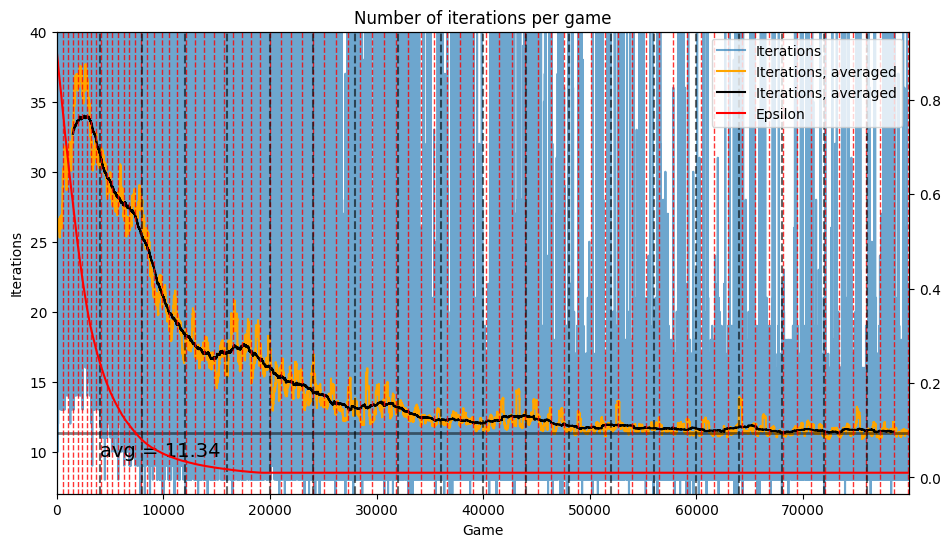

Training: 100%|#########9| 79976/80000 [18:13:37<00:18,  1.33it/s, mag1=9.23, mag2=9.05]

In [8]:
last_update = time.time()

last_checkpoint = checkpoints[-1] if len(checkpoints) > 0 else 0
with tqdm(range(games), desc='Training', smoothing=0.1) as pbar:
    for i in pbar:
        game = generate_balanced_game(board_size, game_config, reward_head=reward_policy)

        outputs = agent.predict(game.observe_board())
        metric = np.mean(np.abs(outputs), axis=(1, 2))
        mag1s.append(metric[0])
        mag2s.append(metric[1])
        pbar.set_postfix({'mag1': metric[0], 'mag2': metric[1]})

        iter_count = train_loop(agent, game, iter_limit=game_iter_limit)
        iters.append(iter_count)
        eps.append(agent.epsilon)

        ctime = time.time()
        if ctime - last_update > 20:
            clear_output(wait=True)
            plot_training_history(iters, eps, checkpoints, vlines=reps, min_ymax=30, average_last=average_result_over)
            display(pbar.container)
            last_update = ctime

        iter_i = len(iters)
        if iter_i - last_checkpoint >= checkpoint_interval:
            last_checkpoint = iter_i
            checkpoints.append(iter_i)
            avg = np.mean(iters[-average_result_over:]) # recent performance
            agent.save_agent(os.path.join(gen_path, f'checkpoints/agent-{avg:0.1f}i-{iter_i / 1000:0.1f}k'))

        if did_replace[0]:
            did_replace[0] = False
            reps.append(iter_i)

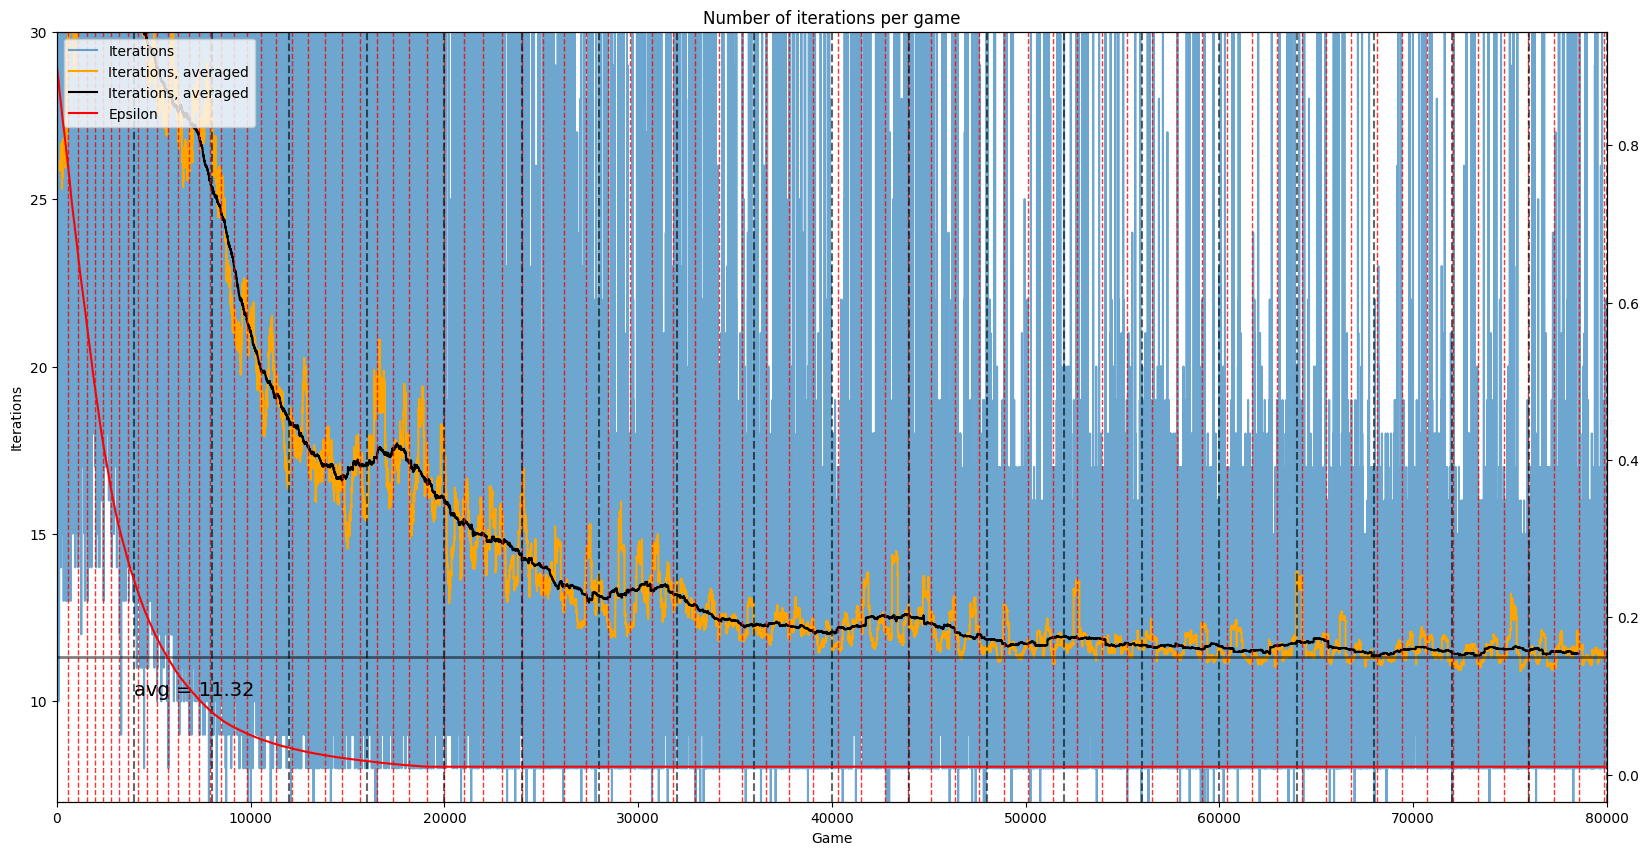

In [11]:
plot_training_history(iters, eps, checkpoints, vlines=reps, min_ymax=30, figsize=(20, 10), show=False)
if report_results:
    plt.savefig(os.path.join(gen_path, 'training.png'), bbox_inches='tight')
plt.show()

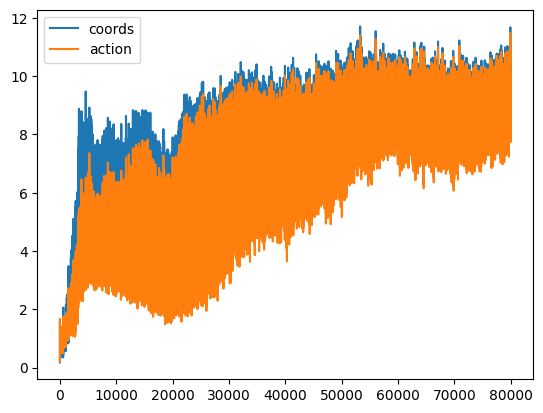

Total number of iterations: 1201413


In [12]:
plt.plot(mag1s, label='coords')
plt.plot(mag2s, label='action')
# plt.yscale('log')
plt.legend()
if report_results:
    plt.savefig(os.path.join(gen_path, 'magnitude.png'), bbox_inches='tight')
plt.show()
print(f'Total number of iterations: {np.sum(iters)}')

In [13]:
if report_results:
    actual_games = len(iters)

    with open(os.path.join(gen_path, 'report.md'), 'w') as report:
        avg = np.mean(iters[-1000:])
        total = np.sum(iters)
        perf = 1e9 / (avg * total)
        report.write(
f'''{gen_header}
# Results
![image](training.png "")

* Average iteration count after {actual_games / 1000:0.1f}k games: {avg:0.2f}
* Total iterations performed: {total}
* Relative training performance: {perf:0.2f}
> 1e9 / (total_iter * avg_iter)

## Model's outputs magnitude history:

![magnitudes](magnitude.png "")

# Configuration

```python


games = {actual_games}
```
''')

In [ ]:
print(f'Shortest game: {np.min(iters)}')
print(f'Longest game: {np.max(iters)}')
print(f'Number of shortest games: {np.sum(np.array(iters) == np.min(iters))}')

Shortest game: 10
Longest game: 21708
Number of shortest games: 1


In [ ]:
game, colormap = decorate_game(generate_balanced_game(board_size, game_config))

agents_play_loop(agent, agent, game, colormap, reset_epsilon=True, delay=1)

Iteration: 12
Turn made by player #0: `Ally soldier`:
	Unit moves: (5, 3) -> (0, 0);
	And takes aciton `Sword attack` with attributes: {'source_unit': 'Ally soldier', 'target_unit': 'None'}

Units alive: 4
Players: 2:
	Player #0 (2 units): `Ally soldier (100 HP)`, `Ally archer (50 HP)`  
	Player #1 (2 units): `Enemy soldier (100 HP)`, `Enemy archer (50 HP)`  
	
    0 1 2 3 4 5 6 7
 0                  0 
 1         ██  ██   1 
 2                  2 
 3                  3 
 4                  4 
 5       ██  ██     5 
 6                  6 
 7                  7 
    0 1 2 3 4 5 6 7

Next move is by player #1: `Enemy soldier`

Game interrupted after 13 iterations


# Visualization

In [ ]:
game, colormap = decorate_game(generate_balanced_game(board_size, game_config))
print_game(game, colormap)

Units alive: 4
Players: 2:
	Player #0 (2 units): `Ally soldier (100 HP)`, `Ally archer (50 HP)`  
	Player #1 (2 units): `Enemy soldier (100 HP)`, `Enemy archer (50 HP)`  
	
    0 1 2 3 4 5 6 7
 0                  0 
 1                  1 
 2       ██         2 
 3 ██               3 
 4 ██               4 
 5                  5 
 6   ██             6 
 7                  7 
    0 1 2 3 4 5 6 7

Next move is by player #0: `Ally soldier`


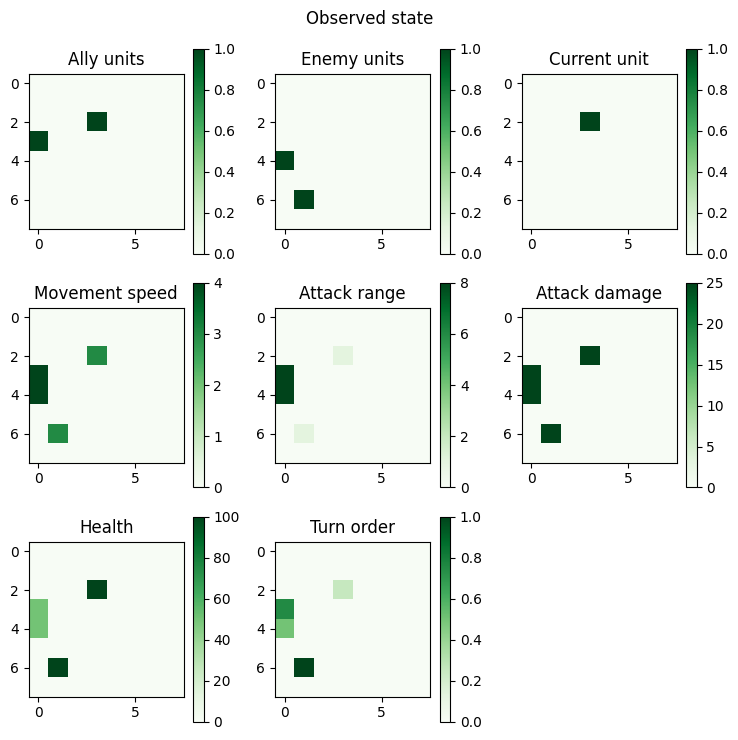

In [ ]:
state = game.observe_board()
plot_featuremaps(
    state, 
    title='Observed state', 
    fm_names=game.CHANNEL_NAMES,
    vmin = -3,
    vmax = 3,
    separate_cbars=True,
    cmap='Greens'
)

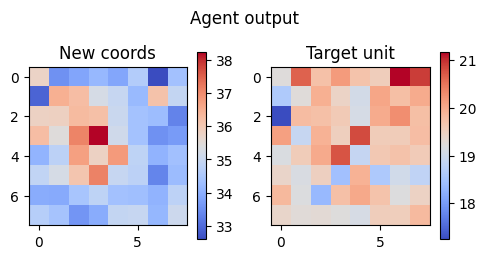

(array([3, 0], dtype=int64), array([3, 6], dtype=int64))


In [ ]:
state = game.observe_board()
output = agent.predict(state)

plot_featuremaps(
    output, 
    title='Agent output', 
    fm_names=['New coords', 'Target unit'],
    separate_cbars=True
)

print(agent.choose_action_vector(state))